In [1]:
!pip install emoji

     |████████████████████████████████| 51kB 1.9MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=260c72f381b848f3caaec007072f9f836a800d852fd125619da78a1297dc3b55
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [2]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

In [10]:
def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False


In [11]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [12]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message



In [13]:
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%d/%m/%y").strftime("%Y-%m-%d")

In [14]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [17]:
parsedData = []
conversationPath = 'fourchat.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

24/01/20, 20:17 - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.



In [18]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df["Date"] = pd.to_datetime(df["Date"])
df = df.dropna()
df["emoji"] = df["Message"].apply(split_count)
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [19]:
df.head(4)

,Date,Time,Author,Message,emoji,urlcount
0,2020-01-24,20:17,Tulikaa,Kal Ka what to do,[],0
1,2020-01-24,20:17,Tulikaa,Are we going,[],0
2,2020-01-24,20:17,Sanjana,Hey children,[],0
3,2020-01-24,20:17,Jason Mendes,I have no clue,[],0


In [26]:
df = df.dropna()

In [27]:
df.Author.unique()

array(['Tulikaa', 'Sanjana', 'Jason Mendes', 'Kevin Winston'],
      dtype=object)

In [28]:
total_messages = df.shape[0]
print(total_messages)

36792


In [29]:
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)

0


In [30]:
emojis = sum(df['emoji'].str.len())
print(emojis)

9851


In [31]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [32]:
links = np.sum(df.urlcount)

In [33]:
print("Group Stats")
print("Messages:",total_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Stats
Messages: 36792
Emojis: 9851
Links: 48


In [34]:
link_messages= df[df['urlcount']>0]
deleted_messages=df[(df["Message"] == " You deleted this message")| (df["Message"] == " This message was deleted.")|(df["Message"] == " You deleted this message.")]
media_messages_df = df[(df['Message'] == ' <Media omitted>')|(df['Message'] == ' image omitted')|(df['Message'] == ' video omitted')|(df['Message'] == ' sticker omitted')]
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(deleted_messages.index)
messages_df = messages_df.drop(link_messages.index)

In [35]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 4955), ('\U0001f929', 723), ('🌚', 458), ('🔥', 423), ('😭', 326), ('🙂', 183), ('🙃', 179), ('♥️', 165), ('🙌', 124), ('🤣', 124), ('🤦🏻\u200d♀️', 110), ('😅', 97), ('🙄', 79), ('😑', 73), ('😊', 67), ('🤦\u200d♂️', 64), ('🎉', 63), ('\U0001f973', 59), ('👻', 53), ('💯', 53), ('😶', 51), ('😒', 47), ('😓', 46), ('👀', 40), ('😌', 37), ('😍', 32), ('🤷\u200d♂️', 31), ('🕺', 31), ('\U0001f97a', 30), ('♥', 28), ('💥', 28), ('🤦🏻\u200d♀', 27), ('💦', 27), ('🕺🏻', 27), ('🌝', 24), ('☺️', 24), ('😬', 23), ('📌', 23), ('🤦\u200d♂', 22), ('💔', 22), ('🌊', 21), ('💪🏻', 20), ('😏', 19), ('🔫', 17), ('\U0001f92f', 16), ('\U0001f928', 15), ('😘', 14), ('🤕', 14), ('😐', 13), ('🐒', 12), ('👏🏼', 12), ('🍕', 12), ('🙈', 12), ('❤️', 12), ('\U0001f970', 11), ('🤞🏻', 11), ('\U0001f9d7\u200d♀️', 11), ('🙊', 9), ('🤢', 9), ('🤓', 8), ('💃🏻', 8), ('💩', 8), ('🐍', 7), ('🐣', 7), ('👍🏻', 7), ('☺', 6), ('💗', 6), ('🙏🏻', 6), ('👌🏻', 6), ('🍻', 6), ('😛', 5), ('😋', 5), ('🌞', 5), ('🙌🏻', 5), ('\U0001f92d', 5), ('💕', 5), ('🐥', 4), ('🤷🏻\u200d♀', 4), ('🙁', 4), 

In [36]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,4955
1,🤩,723
2,🌚,458
3,🔥,423
4,😭,326
...,...,...
192,👑,1
193,🌟,1
194,☹️,1
195,🦍,1


In [37]:
emoji_df.tail(10)

,emoji,count
187,🖕,1
188,👍🏿,1
189,🔅,1
190,📝,1
191,📬,1
192,👑,1
193,🌟,1
194,☹️,1
195,🦍,1
196,💣,1


In [38]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Four - Emojis Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [39]:
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Tulikaa


Emoji Distribution for Sanjana


Emoji Distribution for Jason Mendes


Emoji Distribution for Kevin Winston


Text(0, 0.5, 'Date')

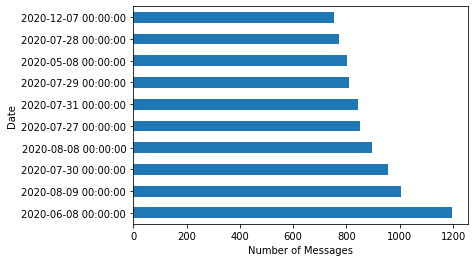

In [40]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

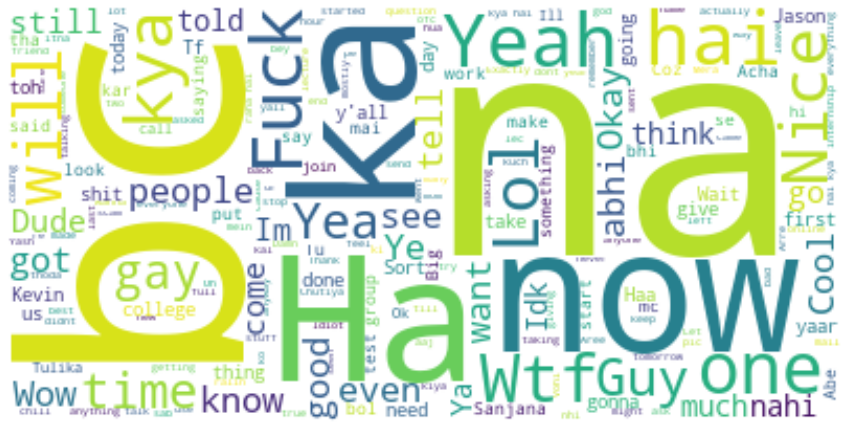

In [42]:
  text = " ".join(review for review in messages_df.Message)
  stopwords = set(STOPWORDS)
  #stopwords.update(["ra", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le","ni","lo","cgpa","percentage","ni"])
  stopwords.update(["cgpa","percentage"])
  # Generate a word cloud image
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(15,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [43]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [48]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount", title='Messages per Month unit')
fig.update_xaxes(nticks=15)
fig.show()

In [46]:
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Tulikaa -
Messages Sent 11916
Media Messages Sent 548
Emojis Sent 2641
Links Sent 0

Stats of Sanjana -
Messages Sent 7646
Media Messages Sent 290
Emojis Sent 2132
Links Sent 0

Stats of Jason Mendes -
Messages Sent 11163
Media Messages Sent 795
Emojis Sent 2900
Links Sent 0

Stats of Kevin Winston -
Messages Sent 4242
Media Messages Sent 122
Emojis Sent 1907
Links Sent 0



In [47]:
print('Longest message')
messages_df.iloc[messages_df['Word_Count'].argmax()]

Longest message


Date                                          2020-07-22 00:00:00
Time                                                        19:43
Author                                                    Sanjana
Message          CGPA to Percentage(Mumbai University)  cgpa 4...
emoji                                                          []
urlcount                                                        0
Letter_Count                                                15019
Word_Count                                                   2146
MessageCount                                                    1
Name: 15406, dtype: object